# Feature Engineering

In [97]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
import plotly.express as px
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
%matplotlib inline
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_classif
import pandas as pd
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")

In [41]:
train_df = pd.read_csv('data/preprocessed/train_df_without_null.csv')
test_df = pd.read_csv('data/preprocessed/test_df_without_null.csv')

## Creating New Features

In [42]:
df = train_df.copy()

### Create a new feature 'TotalIncome'

In [43]:
df['TotalIncome'] = df['ApplicantIncome'] + df['CoapplicantIncome']

### loan to Income ratio 

In [44]:
df['loan_to_income_ratio'] = df['LoanAmount']/df['TotalIncome']

In [45]:
print(max(df['loan_to_income_ratio']))
print(min(df['loan_to_income_ratio']))

0.08271164450210834
0.0025229164914641325


### Binning 'LoanAmount'

In [46]:
print(max(df['LoanAmount']))
print(min(df['LoanAmount']))

700.0
9.0


In [47]:
bins = [0, 100, 200, 300, float('inf')]
labels = ['Low', 'Medium', 'High', 'Very High']
df['LoanAmount_Binned'] = pd.cut(df['LoanAmount'], bins=bins, labels=labels)

In [48]:
for i in labels:
    print(f'loan amount : {i}')
    print(df[df['LoanAmount_Binned'] == i]['Loan_Status'].value_counts())

loan amount : Low
Loan_Status
Y    107
N     47
Name: count, dtype: int64
loan amount : Medium
Loan_Status
Y    266
N    114
Name: count, dtype: int64
loan amount : High
Loan_Status
Y    32
N    19
Name: count, dtype: int64
loan amount : Very High
Loan_Status
Y    17
N    12
Name: count, dtype: int64


In [49]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,TotalIncome,loan_to_income_ratio,LoanAmount_Binned
0,LP001002,Male,No,0,Graduate,No,5849,0.0,146.412162,360.0,1.0,Urban,Y,5849.0,0.025032,Medium
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.000000,360.0,1.0,Rural,N,6091.0,0.021015,Medium
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.000000,360.0,1.0,Urban,Y,3000.0,0.022000,Low
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.000000,360.0,1.0,Urban,Y,4941.0,0.024287,Medium
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.000000,360.0,1.0,Urban,Y,6000.0,0.023500,Medium


In [50]:
df.drop(columns=['ApplicantIncome','CoapplicantIncome','LoanAmount'],inplace=True)

In [51]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,TotalIncome,loan_to_income_ratio,LoanAmount_Binned
0,LP001002,Male,No,0,Graduate,No,360.0,1.0,Urban,Y,5849.0,0.025032,Medium
1,LP001003,Male,Yes,1,Graduate,No,360.0,1.0,Rural,N,6091.0,0.021015,Medium
2,LP001005,Male,Yes,0,Graduate,Yes,360.0,1.0,Urban,Y,3000.0,0.022000,Low
3,LP001006,Male,Yes,0,Not Graduate,No,360.0,1.0,Urban,Y,4941.0,0.024287,Medium
4,LP001008,Male,No,0,Graduate,No,360.0,1.0,Urban,Y,6000.0,0.023500,Medium


## Feature Selection

In [52]:
# Encode categorical variables
label_encoders = {}
for col in ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status',
            'LoanAmount_Binned']:
    label_encoders[col] = LabelEncoder()
    df[col] = label_encoders[col].fit_transform(df[col])

In [53]:
# Normalize numerical columns
scaler = StandardScaler()
numerical_cols = ['Loan_Amount_Term', 'TotalIncome','loan_to_income_ratio']
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

### 1. Variance Threshold Method

In [54]:
# Apply variance threshold-based feature selection
selector = VarianceThreshold(threshold=0.1)  # Adjust the threshold as needed
df_selected = selector.fit_transform(df.drop(columns=['Loan_ID']))

In [55]:
# Get the selected feature indices
selected_indices = selector.get_support(indices=True)

In [56]:
# Get the selected feature names
selected_features = df.columns[selected_indices]

print(f"Selected Features: {selected_features}")

Selected Features: Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'Loan_Amount_Term', 'Credit_History', 'Property_Area',
       'Loan_Status', 'TotalIncome', 'loan_to_income_ratio'],
      dtype='object')


In [57]:
## no column dropped

### 2. Correlation

In [58]:
# Calculate the correlation matrix
correlation_matrix = df.drop(columns=['Loan_ID']).corr()

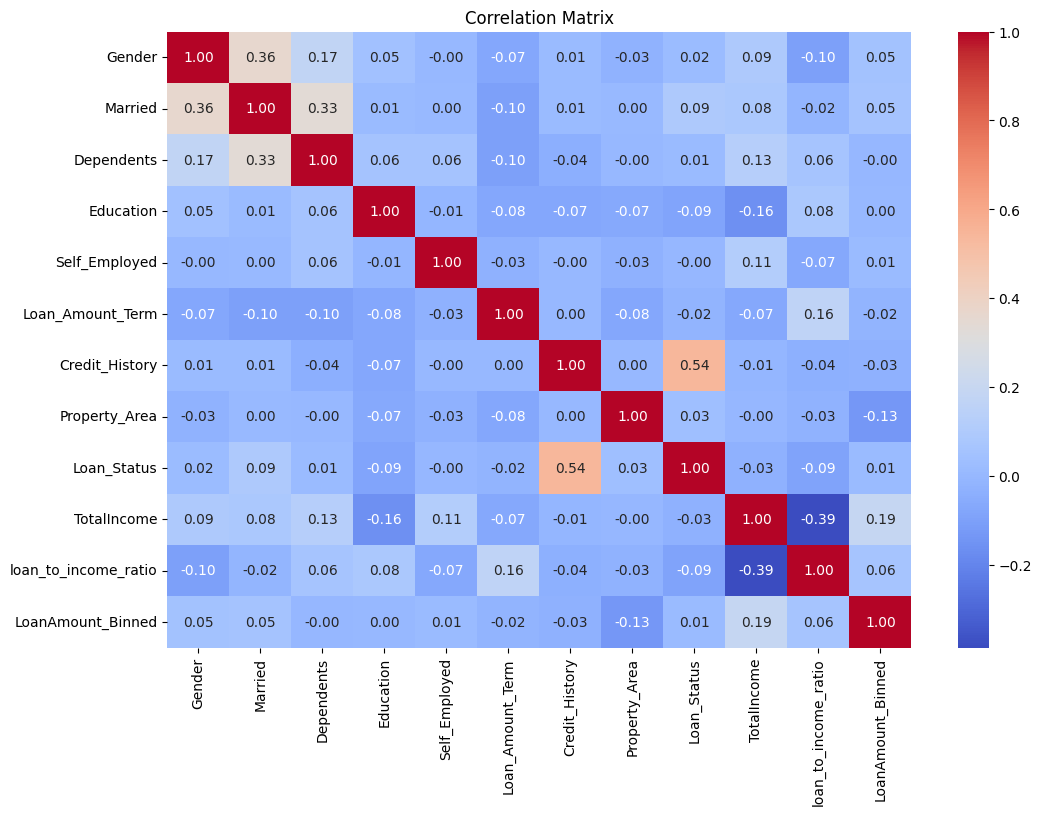

In [59]:
# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


In [60]:
# Select features with highest absolute correlation with target variable
target_correlation = abs(correlation_matrix['Loan_Status']).sort_values(ascending=False)
selected_features = target_correlation.index[1:]  # Exclude the target variable

In [61]:
print(selected_features)

Index(['Credit_History', 'loan_to_income_ratio', 'Married', 'Education',
       'Property_Area', 'TotalIncome', 'Loan_Amount_Term', 'Gender',
       'Dependents', 'LoanAmount_Binned', 'Self_Employed'],
      dtype='object')


In [62]:
## NO feature removed 
## loan_status has maximun correlation with Credit_History as found from EDA

### 3. ANOVA

In [63]:
# Perform feature selection using ANOVA
selector = SelectKBest(score_func=f_classif, k=5)  # Select top 5 features
X_train_selected = selector.fit_transform(df.drop(['Loan_ID', 'Loan_Status'], axis=1), df['Loan_Status'])

# Get the selected feature indices
selected_indices = selector.get_support(indices=True)

# Get the names of the selected features
selected_features = X.columns[selected_indices]

print("Selected Features:", selected_features)

Selected Features: Index(['Married', 'Education', 'Credit_History', 'Property_Area',
       'loan_to_income_ratio'],
      dtype='object')


### 4. Recursive Feature Elimination

In [78]:
# Define the XGBoost model
model = XGBClassifier()

# Initialize RFE with the XGBoost model and number of features to select
rfe = RFE(estimator=model, n_features_to_select=5, step=1)

# Fit RFE to the training data
rfe.fit(df.drop(['Loan_ID', 'Loan_Status'],axis=1), df['Loan_Status'])

# Get the selected features
selected_features = X_train.columns[rfe.support_]

In [77]:
print(selected_features)

Index(['Married', 'Self_Employed', 'Credit_History', 'loan_to_income_ratio',
       'LoanAmount_Binned'],
      dtype='object')


### 5. Exhaustive Feature Selection

In [64]:
# Initialize the XGBoost classifier
model = XGBClassifier()

# Initialize the Exhaustive Feature Selector
efs = EFS(model, min_features=1, max_features=len(df.drop(['Loan_ID', 'Loan_Status'], axis=1) .columns), scoring='accuracy', cv=5)

# Perform feature selection
efs = efs.fit(df.drop(['Loan_ID', 'Loan_Status'], axis=1), df['Loan_Status'])

# Get the selected feature indices
selected_features = list(efs.best_idx_)

Features: 2047/2047

In [73]:
print(df.drop(['Loan_ID', 'Loan_Status'], axis=1).columns[selected_features])

Index(['Married', 'Credit_History', 'LoanAmount_Binned'], dtype='object')


## preparing Dataset

In [79]:
# # Split the data into features and target variable
# X = df.drop(['Loan_ID', 'Loan_Status'], axis=1)
# y = df['Loan_Status']
X = df[['Married', 'Credit_History', 'LoanAmount_Binned']]
y = df['Loan_Status']

In [80]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## XGBoost

In [89]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 1.5, 2]
}

In [90]:
# Initialize KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [91]:
# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=XGBClassifier(),
    param_grid=param_grid,
    scoring='accuracy',
    cv=kf,
    n_jobs=-1
)

In [92]:
# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraint...
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'gamma': [0, 0.1, 0.3],
                         'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': [3, 5, 7], 'min_child_weight': [1, 3, 5],
                         'n_estimators': [50, 100, 150],
                         'reg_alpha': [0, 0.1, 0.5], 'reg_lambda': [1, 1.5, 2],
                         'subsample': [0.6, 0.8, 1.0]},
             scoring='accuracy')

In [93]:
# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

In [94]:
print(f"Best Parameters: {best_params}")
print(f"Best Score: {best_score}")

Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 1.0}
Best Score: 0.8209441352298494


In [95]:
# Use the best model to make predictions on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.42      0.58        43
           1       0.76      0.99      0.86        80

    accuracy                           0.79       123
   macro avg       0.85      0.70      0.72       123
weighted avg       0.83      0.79      0.76       123



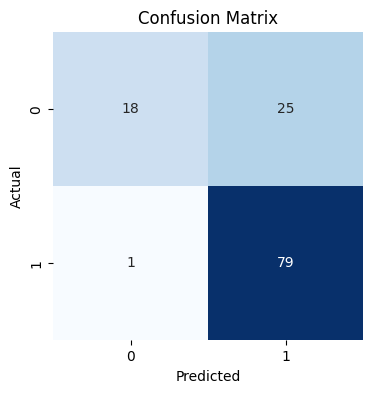

In [100]:
# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()